## Import the needed libraries

In [1]:
import json
import math
import copy
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation

%matplotlib notebook

## Task 1/5: Setting up the modeling environment

### 1. Basic visualization.

In [2]:
basic_scenario = {
    "width": 6,
    "height": 6,
    "cell_size": 1,
    "pedestrian_coordinates": [{"x":1, "y":2}, {"x":2,"y":5}],
    "obstacle_coordinates":[{"x":3, "y":2}],
    "target_coordinates":[{"x":5, "y":4}],
}

In [3]:
state_space = {
    "E": 0,
    "P":1,
    "O":2,
    "T":3,
}

In [4]:
class Scenario: 
    """
    class of scenario, used to create object of different scenario object based on the given json scenario file
    """
    def __init__(self, scenario_setting):
        #preprocess the json data to create basic information for grid visualization and simulation
        self.number_of_cells_x = math.floor(scenario_setting["width"]/scenario_setting["cell_size"])
        self.number_of_cells_y = math.floor(scenario_setting["height"]/scenario_setting["cell_size"])
        self.ped_coordinates = scenario_setting["pedestrian_coordinates"]
        self.obs_coordinates = scenario_setting["obstacle_coordinates"]
        self.tar_coordinates = scenario_setting["target_coordinates"]
        
        #Basic attribute of a scenario, which stores the state of each cell in each step
        #The states value are 0, 1, 2, 3, representing "E", "P", "O", "T" respectively
        self.states = np.zeros((self.number_of_cells_y, self.number_of_cells_x))
        
        #empty list of pedestrian, target, obstacle position
        self.ped_coordinates_list = []
        self.obs_coordinates_list = []
        self.tar_coordinates_list = []
        
    def add_pedestrians(self):
        """"""# get the list of pedestrain positions from the scenario_setting file (json)
        for ped in self.ped_coordinates:
            if  (ped["x"]-1, ped["y"]-1) not in self.ped_coordinates_list:
                # from dict in json file to ped_coordinates_list
                self.ped_coordinates_list.append(  (ped["x"]-1,ped["y"]-1) )
                # update the scenario state according to the given coordinates of pedestrian.
                self.states[ped["x"]-1, ped["y"]-1] = state_space["P"]
            
    def add_obstacles(self):
        """"""
        for obs in self.obs_coordinates:
            if obs['x'] == None:
                break
            elif (obs["x"]-1, obs["y"]-1) not in self.obs_coordinates_list:
                self.obs_coordinates_list.append(  (obs["x"]-1,obs["y"]-1) )
                self.states[obs["x"]-1, obs["y"]-1] = state_space["O"]
            
    def add_targets(self):    
        """"""
        for tar in self.tar_coordinates:
            if  (tar["x"]-1, tar["y"]-1) not in self.tar_coordinates_list:
                self.tar_coordinates_list.append(  (tar["x"]-1,tar["y"]-1) )
                self.states[tar["x"]-1, tar["y"]-1] = state_space["T"]

In [5]:
def set_scenario(scenario):
    #get the "E", "P", "O", "T" coordinates a scenario object called "scenario"
    scenario.add_pedestrians()
    scenario.add_obstacles()
    scenario.add_targets()
    return scenario.states

In [6]:
scenario = Scenario(basic_scenario)
set_scenario(scenario)
scenario.states

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [7]:
def get_color_map():    
    #The method that makes the grid colourful
    cmap = colors.ListedColormap(['white', 'blue', 'red', 'green']) 
    #colors represent empty, pedestrian, obstacle, target respectively
    #bounds = [state_space["empty"], state_space["pedestrian"], state_space["obstacle"], state_space["target"]]
    #colors.BoundaryNorm(bounds, cmap.N)
    return cmap

In [8]:
def get_text(states, ax):
    # write the text "E", "P", "O", "T" in the middle of the cell
    for (i,j), state in np.ndenumerate(states): 
        if state == state_space["P"]:
            ax.text(j, i, "P", ha='center', va='center')
        if state == state_space["O"]:
            ax.text(j, i, "O", ha='center', va='center')
        if state == state_space["T"]:
            ax.text(j, i, "T", ha='center', va='center')    

In [9]:
def get_grid(states, ax):
    #replace axis, labels with grid, beautify the outlook of the grid output
    ax.tick_params(bottom=False, top=False, left=False, right=False, 
                   labelbottom=False, labelleft=False, labelright=False, labeltop=False )
    ax.set_xticks(np.arange(-.5, states.shape[1], 1))
    ax.set_yticks(np.arange(-.5, states.shape[0], 1))
    ax.grid(which='major', color='gray', linestyle='-', linewidth=2)

In [10]:
def get_plot_states(states):
    ##The method that combines get_color_map(), get_text(), get_grid() together and visualize the states
    #add basic figure
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    #add color
    ax.matshow(states, cmap=get_color_map())
    #add text, e.g. 
    get_text(states, ax)
    #remove labels and add grid
    get_grid(states, ax)

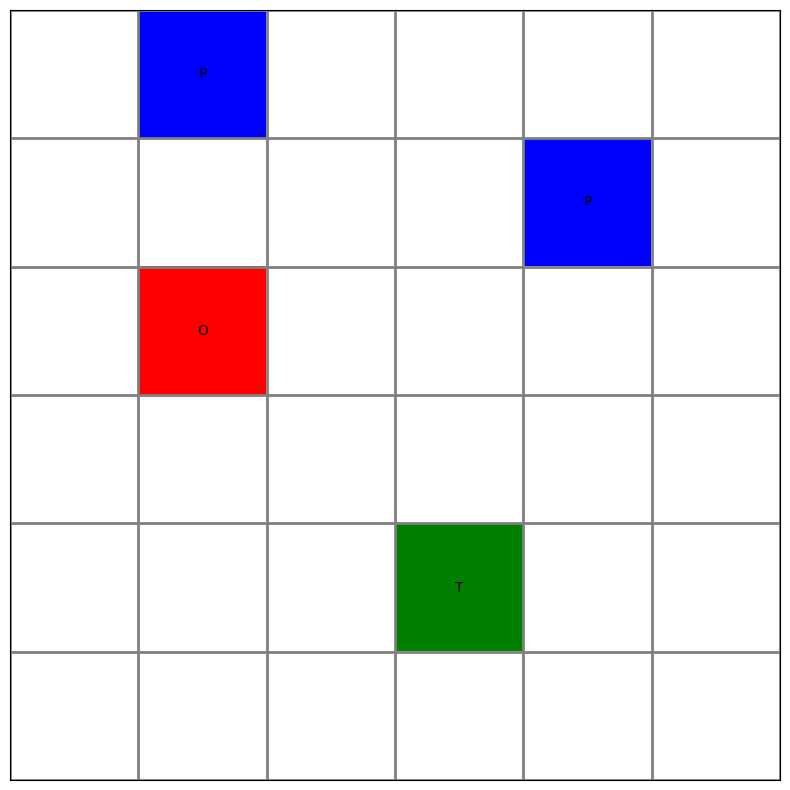

In [11]:
get_plot_states(scenario.states)

### 2. Move the pedestrian according to distance, avoid obstacles

In [12]:
def euclidean_distance(i,j,k,l):
        return np.sqrt(   (i-k)**2 + (j-l)**2  )  #*self.scenario.number_of_cells_y

In [13]:
def cost_func(r, rmax):
    if r < rmax:
        return np.exp(1 / (r**2-rmax**2))
    else:
        return 0

In [14]:
scenario.ped_coordinates_list, scenario.tar_coordinates_list,scenario.obs_coordinates_list

([(0, 1), (1, 4)], [(4, 3)], [(2, 1)])

In [15]:
distances = np.zeros((scenario.number_of_cells_y, scenario.number_of_cells_x))

In [16]:
k,l = scenario.tar_coordinates_list[0]

#calculate distance to the target for each cell in the grid
for i in range(scenario.number_of_cells_y):
    for j in range(scenario.number_of_cells_x):
        distances[i,j] = euclidean_distance(i,j,k,l)
        
#set the obstacle to unlimited large to make the certain cell inaccessible.
for obs in scenario.obs_coordinates_list:
    distances[obs] = 1000000       

In [17]:
#scenario is an object, it will be updated when we run self.scenario.method() . 
#In this way, we don't need to run the code from the beginning of the notebook every time.
scenario = Scenario(basic_scenario)
set_scenario(scenario)
scenario.states

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [18]:
class Automaton:
    """class to calculate distances, utilities and move the pedestrian"""
    def __init__ (self, scenario):
        self.scenario = scenario
        
        self.distances = np.zeros((scenario.number_of_cells_y, scenario.number_of_cells_x))
        self.utility = np.zeros((scenario.number_of_cells_y, scenario.number_of_cells_x))
        
    def euclidean_distance(self,i,j,k,l):
        return np.sqrt(   (i-k)**2 + (j-l)**2  )  #*self.scenario.number_of_cells_  
    
    def on_grid(self, i, j):
        return -1 < i < self.scenario.number_of_cells_y and -1 < j < self.scenario.number_of_cells_x
    
    def reset_pedestrians_positions(self, ped_next_step):
        """"""
        #set the current P value to E on the grid, i.e. empty
        for ped in self.scenario.ped_coordinates_list:
            if (ped[0],ped[1]) not in self.scenario.tar_coordinates_list:
                #only clear the cell when it is not in the target cell
                self.scenario.states[ped[0], ped[1]] = state_space["E"]   
                #besides the value on grid, also clear the old ped_coordinates_list
                self.scenario.ped_coordinates_list = []
                
        #set the value of the next step    
        for ped in ped_next_step:
            if (ped[0],ped[1]) not in self.scenario.tar_coordinates_list: 
            #if the new ped coordinate is not in target, set it to P, otherwise keep the target state_space["T"] 
                self.scenario.states[ped[0], ped[1]] = state_space["P"]   
                self.scenario.ped_coordinates_list.append(ped)
            else:
            #if the new ped coordinate is in target, do not set it to P.     
                self.scenario.ped_coordinates_list.append(ped)
    
    def move_pedestrians(self,diagnal):
        neighbour_offsets_diagnal = [ [-1,0], [0,1], [1,0], [0,-1], [1, 1], [-1, -1], [-1, 1], [1, -1], [0,0] ]
        #     here diagonal is probabily needed ?
        neighbour_offsets = [ [-1,0], [0,1], [1,0], [0,-1], [0,0] ]
        
        #based on the input of method, decide whether we should abandom diagnal neighbour or not.
        if diagnal :
            offsets = neighbour_offsets_diagnal
        else:
            offsets = neighbour_offsets
        
        
        ped_next_step = []    
        
        #consider each pedestrian respectively
        for ped in self.scenario.ped_coordinates_list:
            min_distance = 100000000
            #consider each neighbour offset respectively
            for neighbour_offset in offsets:
                #get the true value of the neighbour
                neighbour = np.add ([ ped[0],ped[1] ], neighbour_offset)
                #calculate euclidean distance
                tar = self.scenario.tar_coordinates_list[0]
                distance = euclidean_distance(neighbour[0], neighbour[1], tar[0], tar[1])
                #consider the case of obstacle, set the distance to infinite large
                if (neighbour[0], neighbour[1]) in self.scenario.obs_coordinates_list:
                    distance = 1000000000
                #make sure that cell is on grid and pick the minimun distance
                if  ( self.on_grid(neighbour[0], neighbour[1]) & (distance<min_distance) ).all(): 
                    neighbour_selected = neighbour
                    min_distance = distance   
            # a list of new ped coordinates for each old ped coordinates respectively        
            ped_next_step.append(neighbour_selected)
        
        #update the grid layout
        self.reset_pedestrians_positions(ped_next_step)
        

In [19]:
def simulation_multiple_steps(scenario, timesteps = None, diagnal = False):
    """"""
    reach_target = False
    data_scenario_states = []

    if timesteps == None:
        timesteps = scenario.number_of_cells_y * scenario.number_of_cells_x
    for k in range(timesteps):
        data_scenario_states.append(np.copy(scenario.states))
        # check whether all pedestrians reach targets
        if k == 0:
            #The first step has to be executed anyway, but the condition in elif cannot be tested. States[-2] is not existing yet.
            automaton.move_pedestrians(diagnal)
        elif ((scenario.states == data_scenario_states[-2]) & (k>=1)).all():
            ### The last step is k, not k+1 steps, because k+1 step is used to check the above condition, i.e. 2 states are equal.
            print("Simulation stopped after", k ,"simulation steps, since all pedestrians are already at their target.")
            break                        
        else:
            automaton.move_pedestrians(diagnal)

    print("Finished simulating", k ,"simulation steps.")

    return data_scenario_states
    

In [20]:
automaton = Automaton(scenario)
simulation_scenario_states = simulation_multiple_steps(scenario)

Simulation stopped after 7 simulation steps, since all pedestrians are already at their target.
Finished simulating 7 simulation steps.


In [21]:
simulation_scenario_states[0:-1] 

[array([[0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 2., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 1., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0.],
      

In [22]:
def get_plot_all_simulation_states(simulation_scenario_states, scenario):
    ##
    #create basic figure
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    plot = plt.matshow(simulation_scenario_states[0], fignum=0, cmap=get_color_map())
    #ax.matshow(simulation_scenario_states[0], cmap=get_color_map())
    #add text in the middle 
    #get_text(simulation_scenario_states, ax)
    #remove labels and add grid
    get_grid(simulation_scenario_states[0], ax)
    
    def init():
        plot.set_data(simulation_scenario_states[0])
        get_text(simulation_scenario_states[0], ax)
        return plot

    def update(i):
        plot.set_data(simulation_scenario_states[i])
        get_text(simulation_scenario_states[i], ax)
        return [plot]
    
    #interval = 1000 * (scenario.number_of_cells_x / parameters.speed_pedestrian)
    interval = 50000
    
    return animation.FuncAnimation(fig, update, init_func=init, frames=len(simulation_scenario_states), interval = interval, repeat=False)
    

<IPython.core.display.Javascript object>


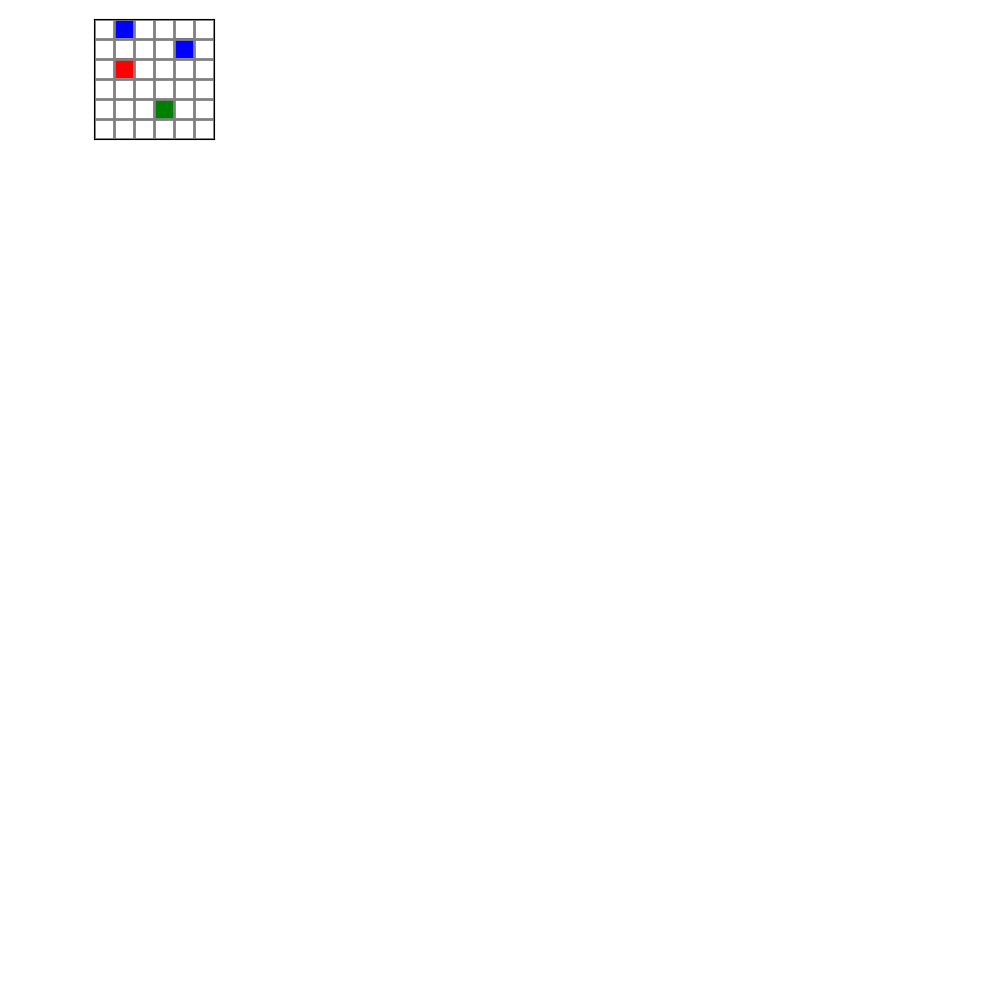

In [23]:
%matplotlib notebook
get_plot_all_simulation_states(simulation_scenario_states, scenario)

## Task 2/5: First step of a single pedestrian 

In [24]:
Task2_scenario = {
    "width": 50,
    "height": 50,
    "cell_size": 1,
    "pedestrian_coordinates": [{"x":5, "y":25}],
    "obstacle_coordinates":[{"x":None, "y":None}],
    "target_coordinates":[{"x":25, "y":25}],
}

In [25]:
scenario_task2 = Scenario(Task2_scenario)
set_scenario(scenario_task2)
scenario_task2.states

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
#get_plot_states(scenario_task2.states)

In [30]:
automaton = Automaton(scenario_task2)
simulation_scenario_states = simulation_multiple_steps(scenario_task2)